In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, LogLocator
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
df = pd.read_csv("/content/cleaned_5250.csv")

In [4]:
df.head()

,name,distance,stellar_magnitude,planet_type,discovery_year,mass_multiplier,mass_wrt,radius_multiplier,radius_wrt,orbital_radius,orbital_period,eccentricity,detection_method
0,11 Comae Berenices b,304.0,4.72307,Gas Giant,2007,19.40000,Jupiter,1.08,Jupiter,1.290000,0.892539,0.23,Radial Velocity
1,11 Ursae Minoris b,409.0,5.01300,Gas Giant,2009,14.74000,Jupiter,1.09,Jupiter,1.530000,1.400000,0.08,Radial Velocity
2,14 Andromedae b,246.0,5.23133,Gas Giant,2008,4.80000,Jupiter,1.15,Jupiter,0.830000,0.508693,0.00,Radial Velocity
3,14 Herculis b,58.0,6.61935,Gas Giant,2002,8.13881,Jupiter,1.12,Jupiter,2.773069,4.800000,0.37,Radial Velocity
4,16 Cygni B b,69.0,6.21500,Gas Giant,1996,1.78000,Jupiter,1.20,Jupiter,1.660000,2.200000,0.68,Radial Velocity


In [3]:
df.tail()

,name,distance,stellar_magnitude,planet_type,discovery_year,mass_multiplier,mass_wrt,radius_multiplier,radius_wrt,orbital_radius,orbital_period,eccentricity,detection_method
5245,XO-7 b,764.0,10.521,Gas Giant,2019,0.709,Jupiter,1.373,Jupiter,0.04421,0.007940,0.04,Transit
5246,YSES 2 b,357.0,10.885,Gas Giant,2021,6.300,Jupiter,1.140,Jupiter,115.00000,1176.500000,0.00,Direct Imaging
5247,YZ Ceti b,12.0,12.074,Terrestrial,2017,0.700,Earth,0.913,Earth,0.01634,0.005476,0.06,Radial Velocity
5248,YZ Ceti c,12.0,12.074,Super Earth,2017,1.140,Earth,1.050,Earth,0.02156,0.008487,0.00,Radial Velocity
5249,YZ Ceti d,12.0,12.074,Super Earth,2017,1.090,Earth,1.030,Earth,0.02851,0.012868,0.07,Radial Velocity


In [5]:
def calc_mass_earth(x):
    if x["mass_wrt"] == "Earth":
        return x["mass_multiplier"]
    elif x["mass_wrt"] == "Jupiter":
        return x["mass_multiplier"] * 317.82838

def calc_radius_earth(x):
    if x["radius_wrt"] == "Earth":
        return x["radius_multiplier"]
    elif x["radius_wrt"] == "Jupiter":
        return x["radius_multiplier"] * 11.209

df["mass_multiplier"] = df.apply(calc_mass_earth, axis=1)
df["radius_multiplier"] = df.apply(calc_radius_earth, axis=1)
df = df.rename(columns = {"mass_multiplier": "mass_earth", "radius_multiplier": "radius_earth"})

In [6]:

df = df.drop(columns = ["stellar_magnitude", "mass_wrt", "radius_wrt"])

df.isna().any()

,0
name,False
distance,True
planet_type,False
discovery_year,False
mass_earth,True
radius_earth,True
orbital_radius,True
orbital_period,False
eccentricity,False
detection_method,False


In [7]:
# Dropping rows with null values for relevant attributes
df = df.dropna(subset = ["mass_earth", "radius_earth"])
df.describe(include="all")

,name,distance,planet_type,discovery_year,mass_earth,radius_earth,orbital_radius,orbital_period,eccentricity,detection_method
count,5215,5198.000000,5215,5215.000000,5215.000000,5215.000000,4933.000000,5.215000e+03,5215.000000,5215
unique,5215,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,11
top,YZ Ceti d,NaN,Neptune-like,NaN,NaN,NaN,NaN,NaN,NaN,Transit
freq,1,NaN,1825,NaN,NaN,NaN,NaN,NaN,NaN,3927
mean,NaN,2164.641016,NaN,2015.739597,457.464923,5.607549,6.990528,4.823558e+02,0.063739,NaN
std,NaN,3252.374090,NaN,4.305650,3762.884312,5.313928,139.065816,1.686071e+04,0.141412,NaN
min,NaN,4.000000,NaN,1992.000000,0.020000,0.296000,0.005800,5.475702e-04,-0.520000,NaN
25%,NaN,384.250000,NaN,2014.000000,3.950000,1.750000,0.053200,1.259411e-02,0.000000,NaN
50%,NaN,1370.000000,NaN,2016.000000,8.450000,2.734996,0.102700,3.449692e-02,0.000000,NaN
75%,NaN,2770.000000,NaN,2018.500000,152.827777,11.545270,0.282900,1.423682e-01,0.060000,NaN


In [8]:
df["eccentricity"] = df["eccentricity"].apply(abs)

In [9]:
# Converting attributes with values differing in magnitude to logarithmic representation
log_mass_earth = np.log10(df["mass_earth"])
log_radius_earth = np.log10(df["radius_earth"])
log_orbital_period = np.log10(df["orbital_period"])
log_orbital_radius = np.log10(df["orbital_radius"])

# Function for converting axis ticks from logarithmic to linear notation
def log_to_lin(x, pos):
    return f"{10**x:.2f}"

df.tail(10)

,name,distance,planet_type,discovery_year,mass_earth,radius_earth,orbital_radius,orbital_period,eccentricity,detection_method
5240,XO-2 S c,494.0,Gas Giant,2014,435.424881,13.562890,0.47560,0.330732,0.15,Radial Velocity
5241,XO-3 b,695.0,Gas Giant,2007,2316.968890,15.804690,0.04760,0.008761,0.29,Transit
5242,XO-4 b,889.0,Gas Giant,2008,451.316300,14.011250,0.05524,0.011225,0.00,Transit
5243,XO-5 b,901.0,Gas Giant,2008,378.215772,12.778260,0.05150,0.011499,0.00,Transit
5244,XO-6 b,768.0,Gas Giant,2016,1398.444872,23.202630,0.08150,0.010404,0.00,Transit
5245,XO-7 b,764.0,Gas Giant,2019,225.340321,15.389957,0.04421,0.007940,0.04,Transit
5246,YSES 2 b,357.0,Gas Giant,2021,2002.318794,12.778260,115.00000,1176.500000,0.00,Direct Imaging
5247,YZ Ceti b,12.0,Terrestrial,2017,0.700000,0.913000,0.01634,0.005476,0.06,Radial Velocity
5248,YZ Ceti c,12.0,Super Earth,2017,1.140000,1.050000,0.02156,0.008487,0.00,Radial Velocity
5249,YZ Ceti d,12.0,Super Earth,2017,1.090000,1.030000,0.02851,0.012868,0.07,Radial Velocity


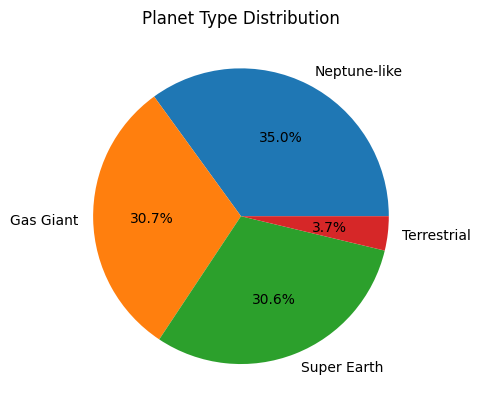

In [10]:
# Planet type piechart
planet_counts = df["planet_type"].value_counts()
plt.pie(planet_counts, labels=planet_counts.index, autopct="%1.1f%%")
plt.title("Planet Type Distribution")
plt.show()

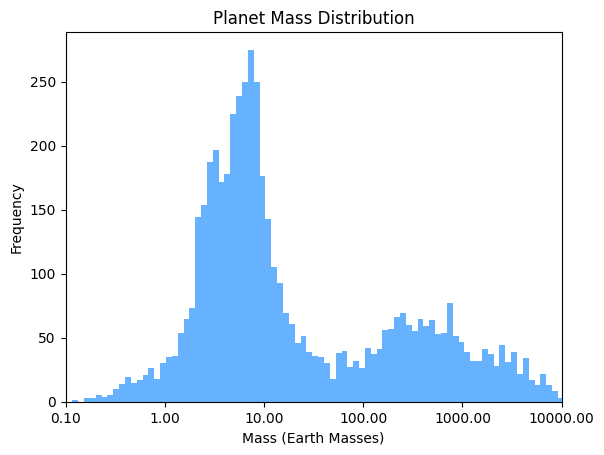

In [11]:
# Planet mass histogram
plt.hist(log_mass_earth, bins=120, color="#66B2FF")
plt.title("Planet Mass Distribution")
plt.xlabel("Mass (Earth Masses)")
plt.ylabel("Frequency")
plt.xlim(-1, 4)
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.show()

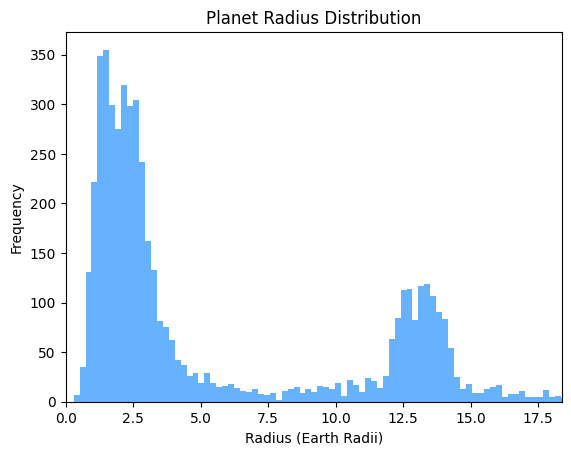

In [12]:
# Planet radius histogram
plt.hist(df["radius_earth"], bins=350, color="#66B2FF")
plt.title("Planet Radius Distribution")
plt.xlabel("Radius (Earth Radii)")
plt.ylabel("Frequency")
plt.xlim(0, df["radius_earth"].quantile(0.99))
plt.show()

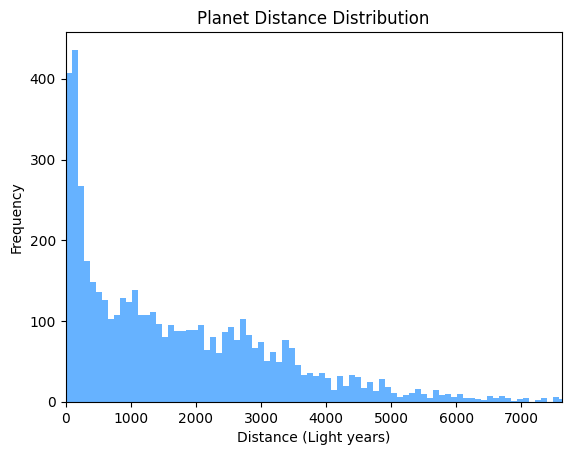

In [13]:
# Planet distance histogram
plt.hist(df["distance"].dropna(), bins=300, color="#66B2FF")
plt.title("Planet Distance Distribution")
plt.xlabel("Distance (Light years)")
plt.ylabel("Frequency")
plt.xlim(0, df["distance"].quantile(0.97))
plt.show()

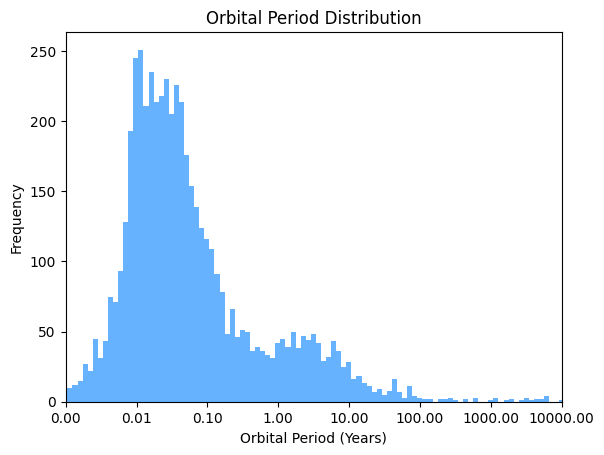

In [14]:
# Orbital period histogram
plt.hist(log_orbital_period, bins=130, color="#66B2FF")
plt.title("Orbital Period Distribution")
plt.xlabel("Orbital Period (Years)")
plt.ylabel("Frequency")
plt.xlim(-3, 4)
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.show()

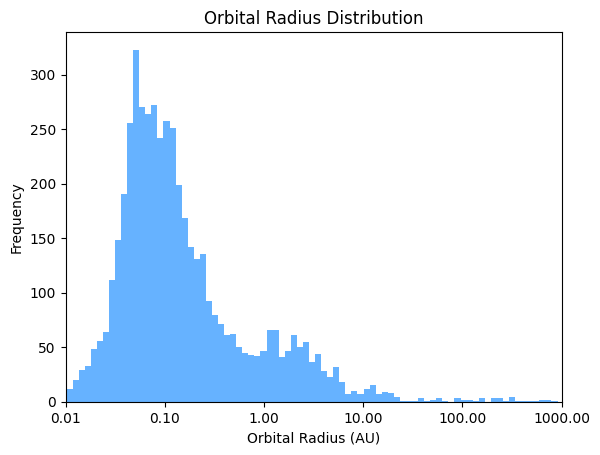

In [15]:
# Orbital radius histogram
plt.hist(log_orbital_radius, bins=100, color="#66B2FF")
plt.title("Orbital Radius Distribution")
plt.xlabel("Orbital Radius (AU)")
plt.ylabel("Frequency")
plt.xlim(-2, 3)
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.show()

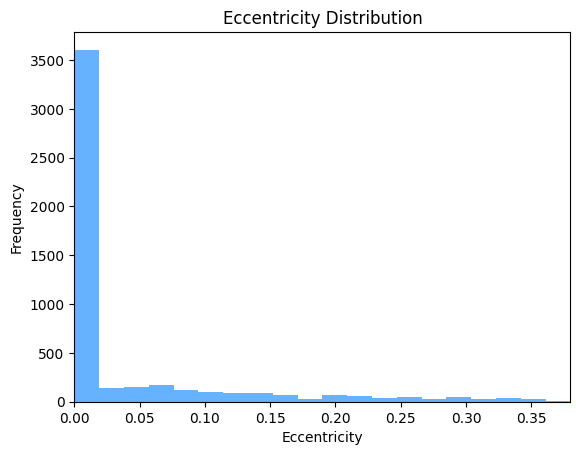

In [16]:
# Eccentricity histogram
plt.hist(df["eccentricity"], bins=50, color="#66B2FF")
plt.title("Eccentricity Distribution")
plt.xlabel("Eccentricity")
plt.ylabel("Frequency")
plt.xlim(0, df["eccentricity"].quantile(0.95))
plt.show()

<ipython-input-17-f55c3f852e48>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="discovery_year", data=df, palette="crest")


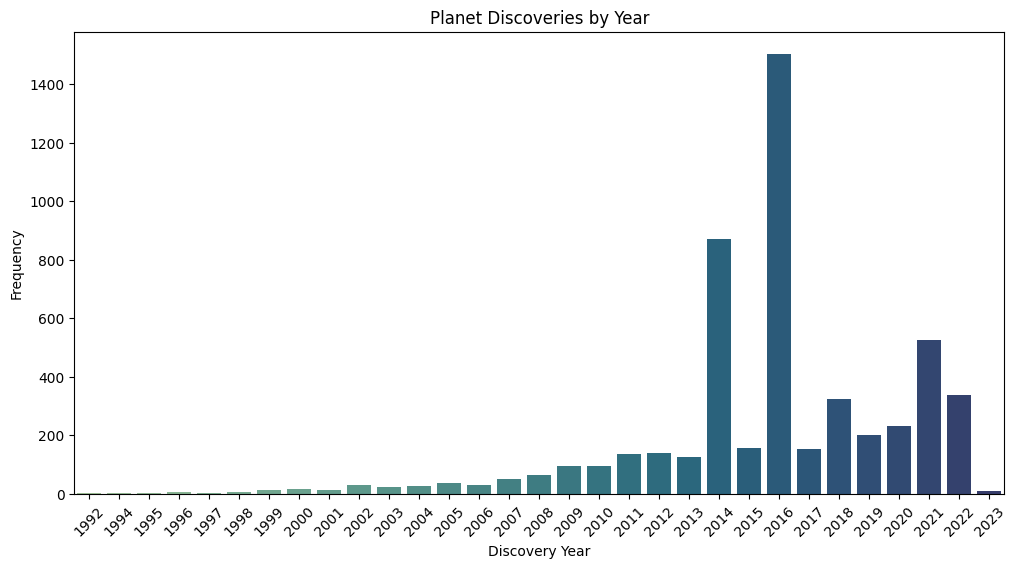

In [17]:
# Discovery year barplot
plt.figure(figsize=(12, 6))
sns.countplot(x="discovery_year", data=df, palette="crest")
plt.title("Planet Discoveries by Year")
plt.xlabel("Discovery Year")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

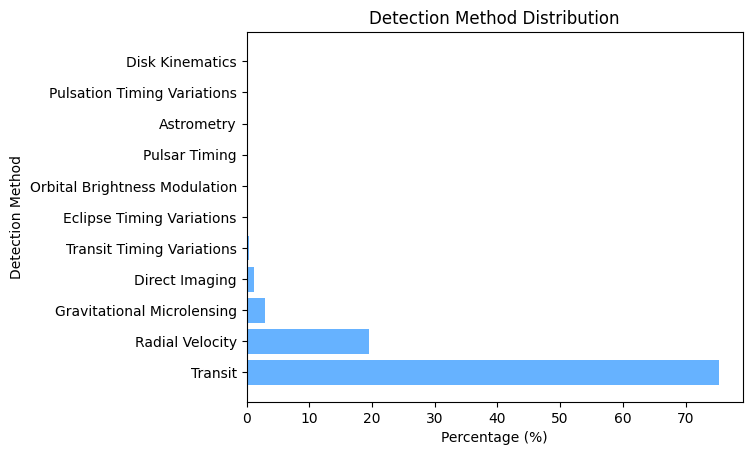

In [18]:
# Detection method barplot
detection_ratios = df["detection_method"].value_counts() / len(df) * 100
plt.barh( detection_ratios.index, detection_ratios, color="#66B2FF")
plt.title("Detection Method Distribution")
plt.ylabel("Detection Method")
plt.xlabel("Percentage (%)")
plt.show()

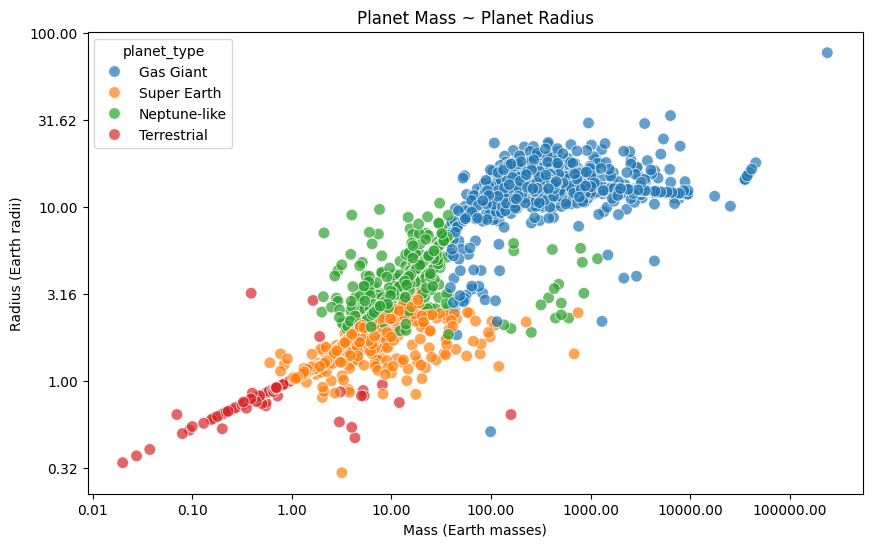

In [19]:
# Planet Mass ~ Planet Radius
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=log_mass_earth, y=log_radius_earth, hue="planet_type", alpha=0.7, s=70)
plt.title("Planet Mass ~ Planet Radius")
plt.xlabel("Mass (Earth masses)")
plt.ylabel("Radius (Earth radii)")
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.show()

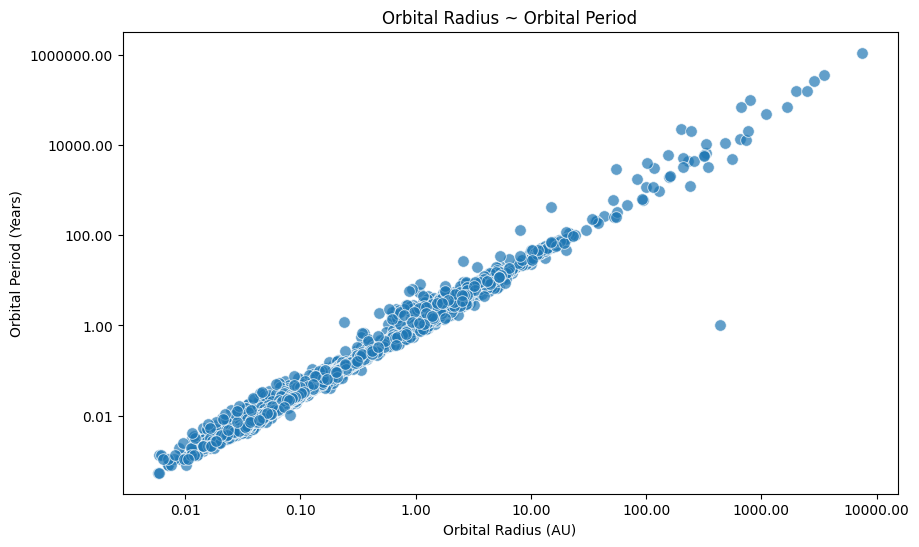

In [20]:
# Orbital Radius ~ Orbital Period
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=log_orbital_radius, y=log_orbital_period, alpha=0.7, s=70)
plt.title("Orbital Radius ~ Orbital Period")
plt.xlabel("Orbital Radius (AU)")
plt.ylabel("Orbital Period (Years)")
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.show()

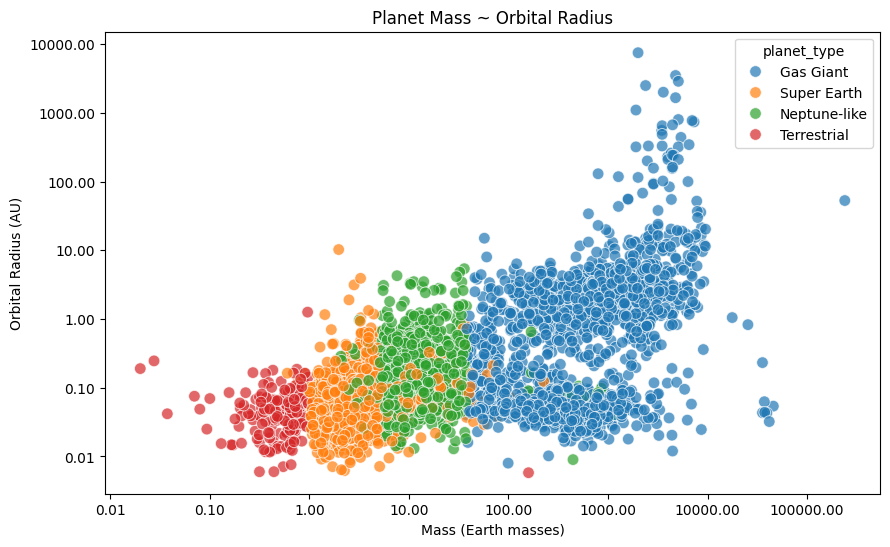

In [21]:
# Planet Mass ~ Orbital Radius
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=log_mass_earth, y=log_orbital_radius, hue="planet_type", alpha=0.7, s=70)
plt.title("Planet Mass ~ Orbital Radius")
plt.xlabel("Mass (Earth masses)")
plt.ylabel("Orbital Radius (AU)")
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.show()

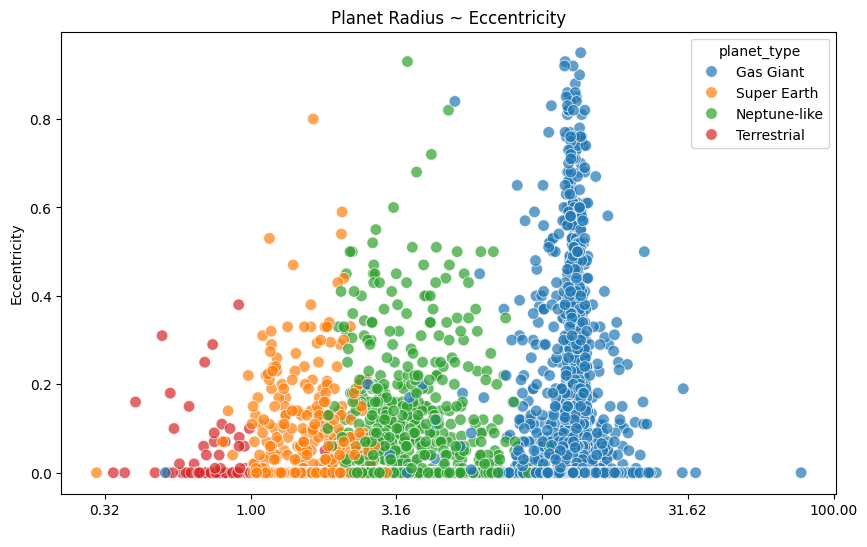

In [22]:
# Planet Radius ~ Eccentricity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=log_radius_earth, y="eccentricity", hue="planet_type", alpha=0.7, s=70)
plt.title("Planet Radius ~ Eccentricity")
plt.xlabel("Radius (Earth radii)")
plt.ylabel("Eccentricity")
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.show()

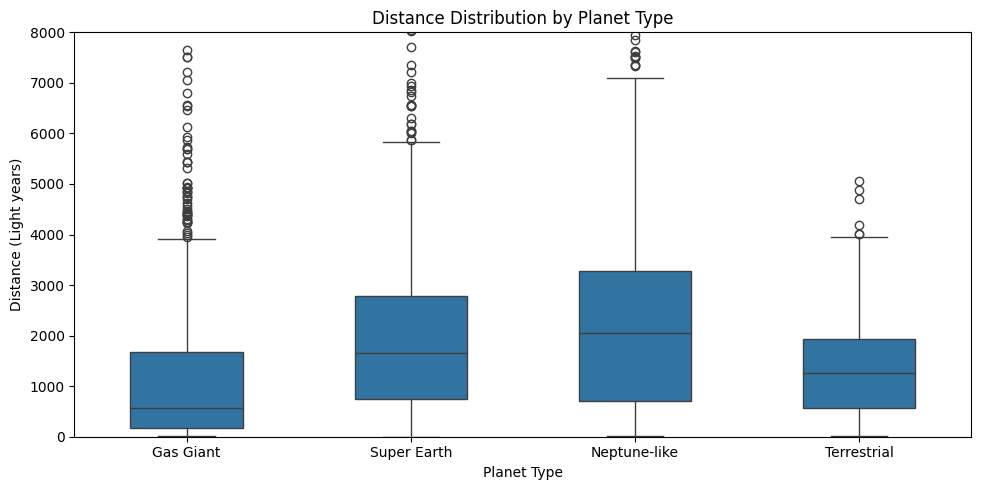

In [23]:
# Planet Type ~ Distance
plt.figure(figsize=(10, 5))
sns.boxplot(x="planet_type", y="distance", data=df, width=0.5)
plt.title("Distance Distribution by Planet Type")
plt.xlabel("Planet Type")
plt.ylabel("Distance (Light years)")
plt.tight_layout()
plt.ylim(0, 8000)
plt.show()

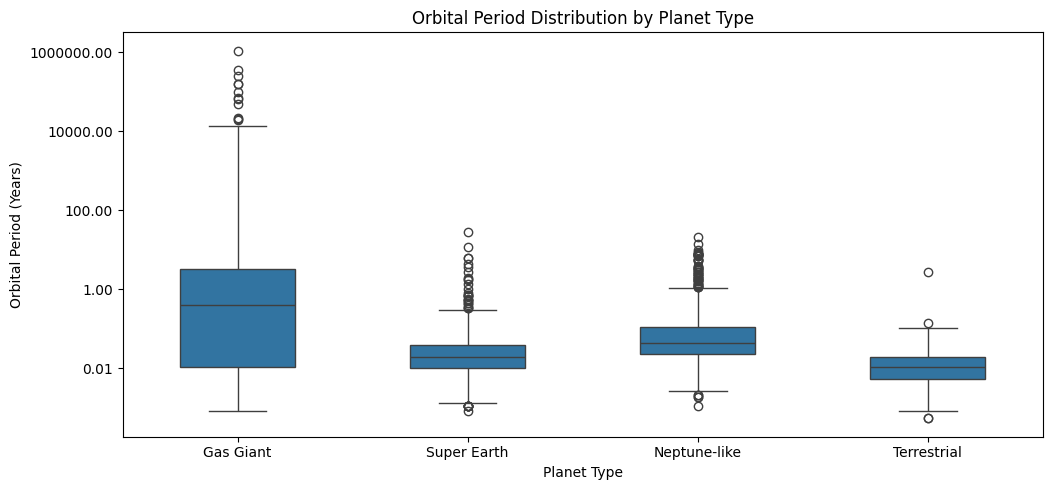

In [24]:
# Planet Type ~ Orbital Period
plt.figure(figsize=(10, 5))
sns.boxplot(x="planet_type", y=log_orbital_period, data=df, width=0.5)
plt.title("Orbital Period Distribution by Planet Type")
plt.xlabel("Planet Type")
plt.ylabel("Orbital Period (Years)")
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.show()

In [25]:
# Dropping all rows with null values (orbital_radius and distance)
df = df.dropna()

# Defining condition for habitability
condition = (
    (df["mass_earth"] > 0.1) & (df["mass_earth"] < 10.0) &
    (df["radius_earth"] > 0.5) & (df["radius_earth"] < 2.5) &
    (df["eccentricity"] < 0.2) &
    (df["orbital_radius"] > 0.38) & (df["orbital_radius"] < 10.0))

# Labeling data according to habitability condition
df["habitable"] = np.where(condition, True, False)

# Counting planets labeled as habitable
df["habitable"].value_counts()

<ipython-input-25-3b765cb30547>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["habitable"] = np.where(condition, True, False)


,count
habitable,
False,4856
True,60


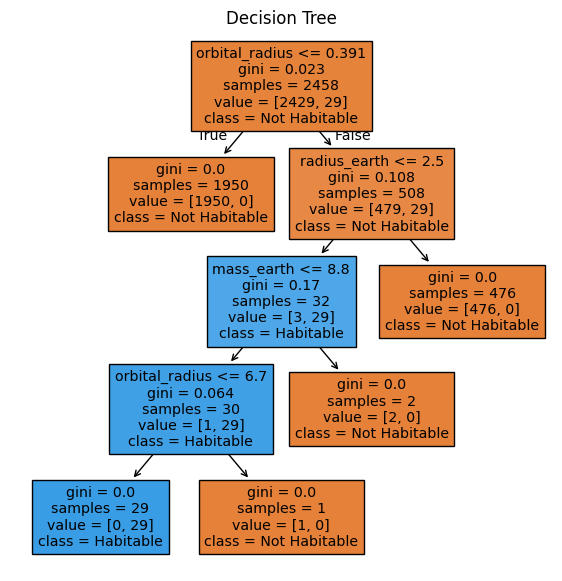

In [26]:
X = df[["mass_earth", "radius_earth", "eccentricity", "orbital_radius"]]
y = df["habitable"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)

plt.figure(figsize=(7, 7))
plot_tree(classifier, filled=True, feature_names=X.columns, class_names=["Not Habitable", "Habitable"])
plt.title("Decision Tree")
plt.show()

In [27]:
# Classifier performance evaluation
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Decision Tree Accuracy:", accuracy)
print("Decision Tree Precision:", precision)
print("Decision Tree Recall:", recall)

Decision Tree Accuracy: 0.9979658258746948
Decision Tree Precision: 0.9333333333333333
Decision Tree Recall: 0.9032258064516129


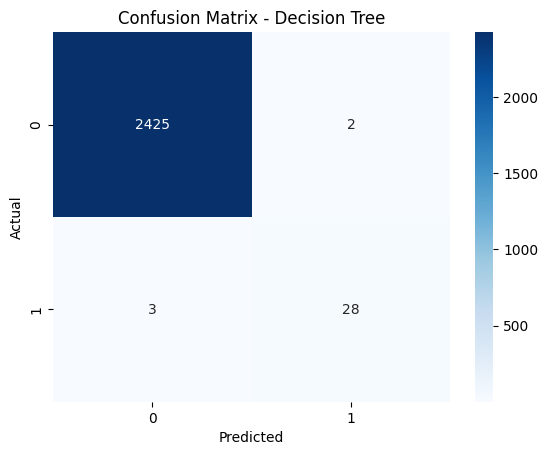

In [28]:
# Plotting confusion matrix for model evaluation
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

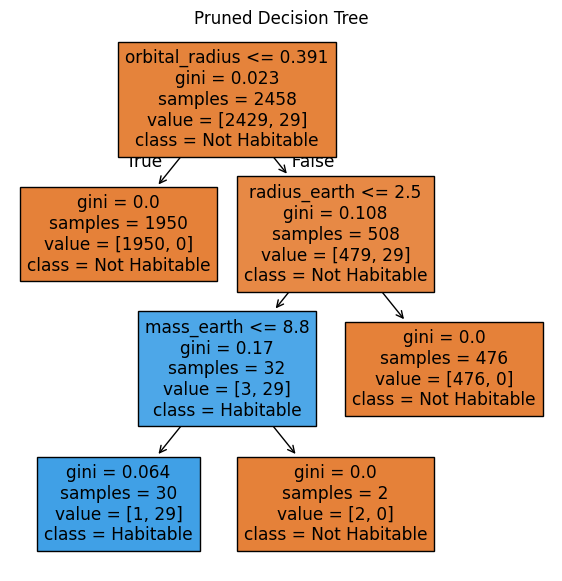

In [29]:
# Pruning decision tree to reduce complexity
pruned = DecisionTreeClassifier(max_depth=3, random_state=42)
pruned.fit(X_train, y_train)

# Plotting pruned decision tree
plt.figure(figsize=(7, 7))
plot_tree(pruned, filled=True, feature_names=X.columns, class_names=["Not Habitable", "Habitable"])
plt.title("Pruned Decision Tree")
plt.show()

In [30]:
# Classifier performance evaluation
y_pred_pruned = pruned.predict(X_test)
accuracy_pruned = accuracy_score(y_test, y_pred_pruned)
precision_pruned = precision_score(y_test, y_pred_pruned)
recall_pruned = recall_score(y_test, y_pred_pruned)
cm2 = confusion_matrix(y_test, y_pred_pruned)

print("Pruned Decision Tree Accuracy:", accuracy_pruned)
print("Pruned Decision Tree Precision:", precision_pruned)
print("Pruned Decision Tree Recall:", recall_pruned)

Pruned Decision Tree Accuracy: 0.9979658258746948
Pruned Decision Tree Precision: 0.9333333333333333
Pruned Decision Tree Recall: 0.9032258064516129


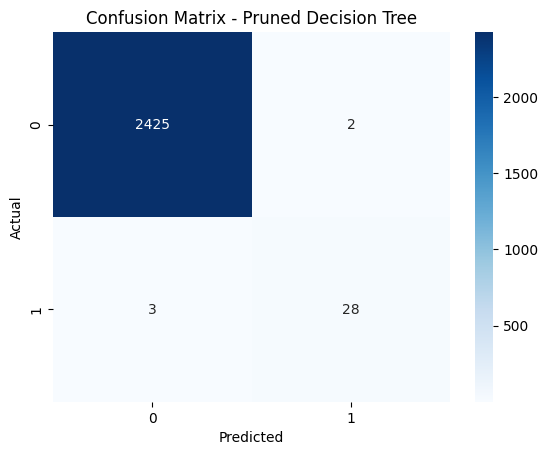

In [31]:
# Plotting confusion matrix for model evaluation
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Pruned Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

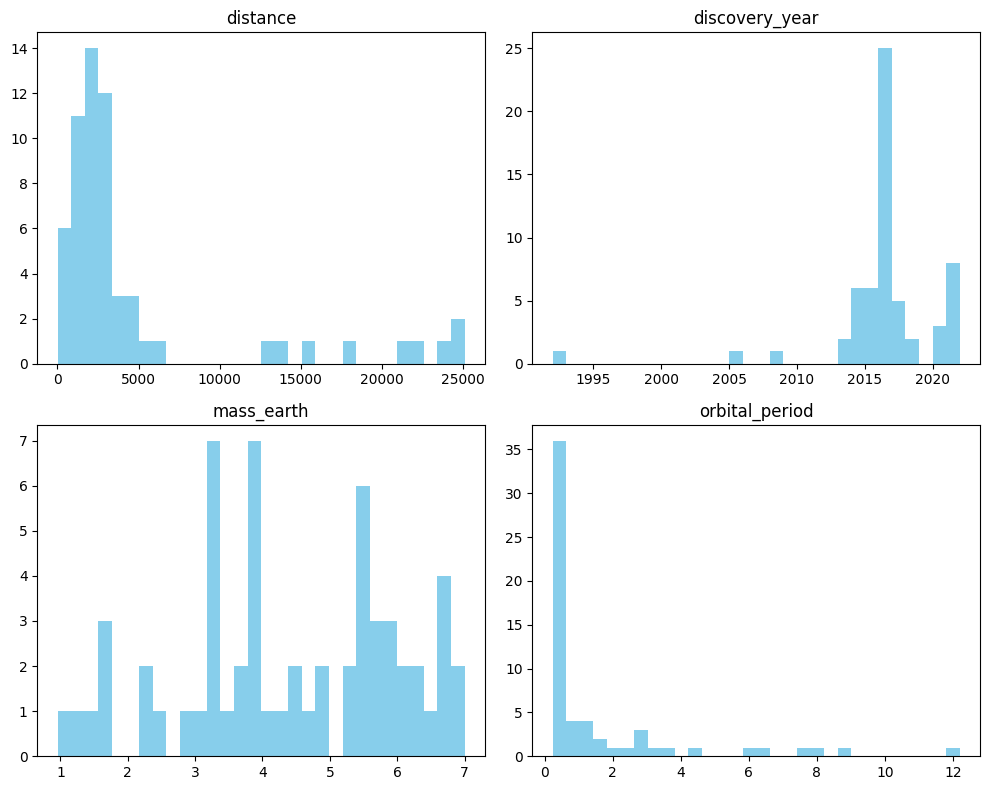

In [32]:
# Brief overview of planets labeled as habitable
pot_hab = df.loc[df["habitable"]==True]
plt_hab = pot_hab[["distance", "discovery_year", "mass_earth", "orbital_period"]]
plt_hab.hist(bins=30, figsize=(10, 8), layout=(2, 2), color="skyblue", grid=False)
plt.tight_layout()
plt.show()

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
# Create a Random Forest classifier with 100 trees
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using your training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [36]:
# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model's performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Precision:", precision_rf)
print("Random Forest Recall:", recall_rf)


Random Forest Accuracy: 0.9979658258746948
Random Forest Precision: 0.9333333333333333
Random Forest Recall: 0.9032258064516129


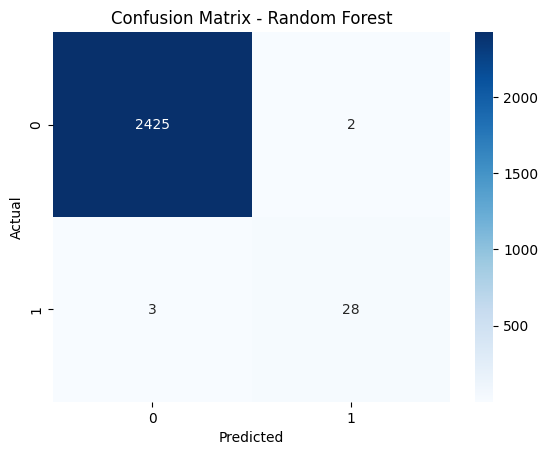

In [37]:
# Plot the confusion matrix
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

                      Model  Accuracy  Precision    Recall
0             Decision Tree  0.997966   0.933333  0.903226
1      Pruned decision tree  0.997966   0.933333  0.903226
2  Random Forest Classifier  0.997966   0.933333  0.903226


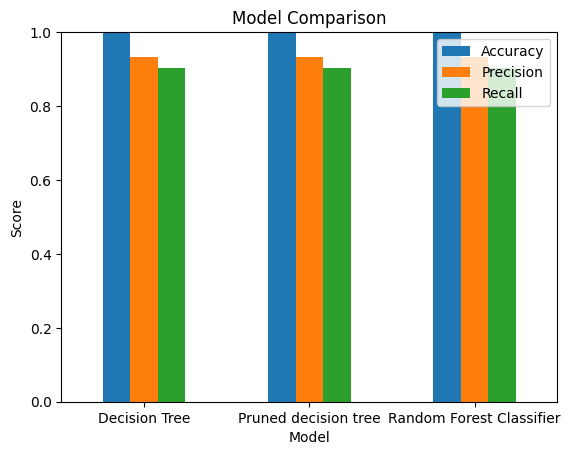

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have these values computed for each model
results = [
    {
        "Model": "Decision Tree",
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
    },
    {
        "Model": "Pruned decision tree",
        "Accuracy": accuracy_pruned,
        "Precision": precision_pruned,
        "Recall": recall_pruned
    },
    {
        "Model": "Random Forest Classifier",
        "Accuracy":accuracy_rf,
        "Precision": precision_rf,
        "Recall": recall_rf
    },
]

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print results
print(results_df)

# Plot the comparison
results_df.plot(x="Model", y=["Accuracy", "Precision", "Recall"], kind="bar")

# Customize plot
plt.title("Model Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)  # Set y-axis range between 0 and 1
plt.legend()
plt.xticks(rotation=0)  # Keep model names horizontal

# Show plot
plt.show()